In [2]:
import tensorflow as tf

In [ ]:
pip install imageio

In [ ]:
pip install git+https://github.com/tensorflow/docs

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

c:\Users\Praveena\Documents\GenAI Lab\GenAI\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


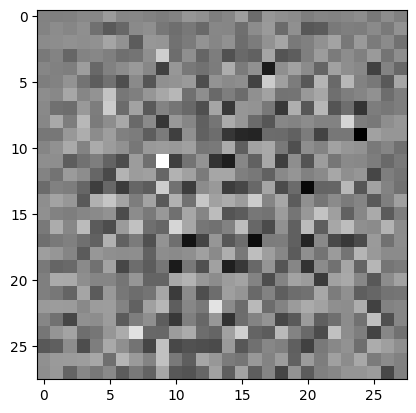

In [16]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00175885]], shape=(1, 1), dtype=float32)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [33]:
# Save and load functions
def save_models(generator, discriminator, generator_path="generator.h5", discriminator_path="discriminator.h5"):
    generator.save(generator_path)
    discriminator.save(discriminator_path)
    print("Models saved successfully.")

def load_models(generator_path="generator.h5", discriminator_path="discriminator.h5"):
    loaded_generator = tf.keras.models.load_model(generator_path)
    loaded_discriminator = tf.keras.models.load_model(discriminator_path)
    print("Models loaded successfully.")
    return loaded_generator, loaded_discriminator

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss , disc_loss

In [30]:
def train(dataset, epochs):
  generator_losses = []
  discriminator_losses = []

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss , disc_loss = train_step(image_batch)
      generator_losses.append(gen_loss.numpy())
      discriminator_losses.append(disc_loss.numpy())

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
  
  print("Generator Losses:", generator_losses)
  print("Discriminator Losses:", discriminator_losses)

  # Save the models after training
  save_models(generator, discriminator)
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [34]:
save_models(generator, discriminator)

Models saved successfully.


In [31]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

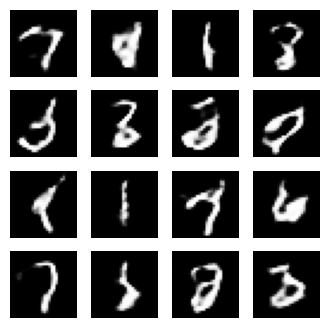

Time for epoch 50 is 67.41401433944702 sec
Epoch 50, Generator Loss: 0.9695972800254822, Discriminator Loss: 1.1434977054595947
Generator Losses: [np.float32(0.6594559), np.float32(0.6430485), np.float32(0.64666766), np.float32(0.6278028), np.float32(0.63682175), np.float32(0.6366598), np.float32(0.6366454), np.float32(0.65276325), np.float32(0.64831555), np.float32(0.6252657), np.float32(0.6383157), np.float32(0.6293999), np.float32(0.65525305), np.float32(0.65914917), np.float32(0.68227804), np.float32(0.68356866), np.float32(0.6865216), np.float32(0.7094356), np.float32(0.6918148), np.float32(0.694344), np.float32(0.7004303), np.float32(0.7147017), np.float32(0.70897335), np.float32(0.7179542), np.float32(0.75911367), np.float32(0.76260185), np.float32(0.78367186), np.float32(0.77540153), np.float32(0.7913594), np.float32(0.78846574), np.float32(0.778897), np.float32(0.77849334), np.float32(0.78632057), np.float32(0.82308376), np.float32(0.8354506), np.float32(0.8151663), np.float32

NameError: name 'save_models' is not defined

In [32]:
train(train_dataset, EPOCHS)

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [36]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

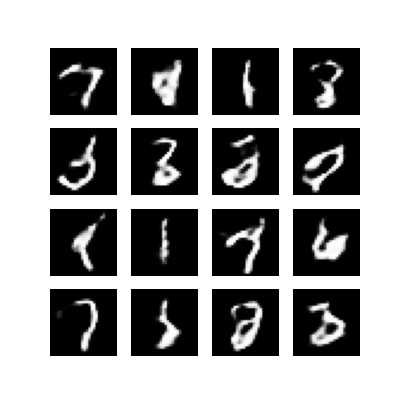

In [37]:
display_image(EPOCHS)

In [38]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\Praveena\AppData\Local\Temp\ipykernel_15024\1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Praveena\AppData\Local\Temp\ipykernel_15024\1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



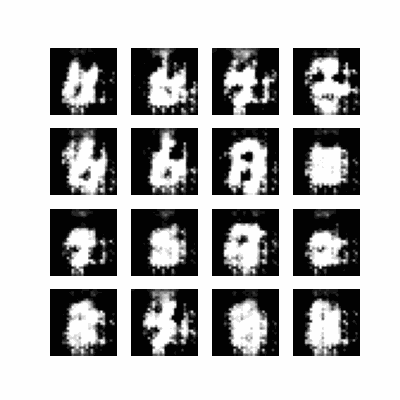

In [39]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)